<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DDDM/blob/main/COIN/heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Travelling salesperson problem



In order to *measure time*, let's have a small auxiliary routine to print that out when we want to see it.

In [223]:
from time import time
def timestamp(start):
    ms = 1000 * (time() - start)
    print(f'That took {ms:.2f} ms of runtime')

We create a set of vertices to be "cities" on a map.

In [224]:
import networkx as nx
from random import gauss
n = 6 # graph order = vertex count
mean = 5 # mean position
sd = 2 # position standard deviation
gpos = { v : (gauss(mean, sd),gauss(mean, sd)) for v in range(n) } # positions of the vertices
G = nx.complete_graph(n) # a graph where everyone is connected
print(G)

Graph with 6 nodes and 15 edges


Let's add edge costs that are proportional to Euclidean distances with some additive noise.

In [225]:
from math import sqrt

def eucl(p1, p2):
  (vx, vy) = p1
  (wx, wy) = p2
  dx = vx - wx # horizontal difference
  dy = vy - wy # vertical difference
  return sqrt(dx**2 + dy**2) # Pythagoras

from random import random

def weight(v, w):
  return eucl(gpos[v], gpos[w]) + random()

cost = []
W = dict()
for e in G.edges(): # for each vertex
  v, w = e
  cost.append(weight(v, w))
  W[e] = cost[-1]

nx.set_edge_attributes(G, W, "cost")

print(len(cost), min(cost), max(cost), G[0][1]['cost'])

15 0.6638840671397311 3.655909033343712 2.91315405509562


Some parameters for the visualizations we will be making. Do not worry about understanding these unless you are a programmer, but play with them to see what happens if you change the numbers.

In [226]:
opt = { 'node_color': 'white', 'font_color': 'black' }
opt['with_labels'] = n <= 30
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7) # big figure

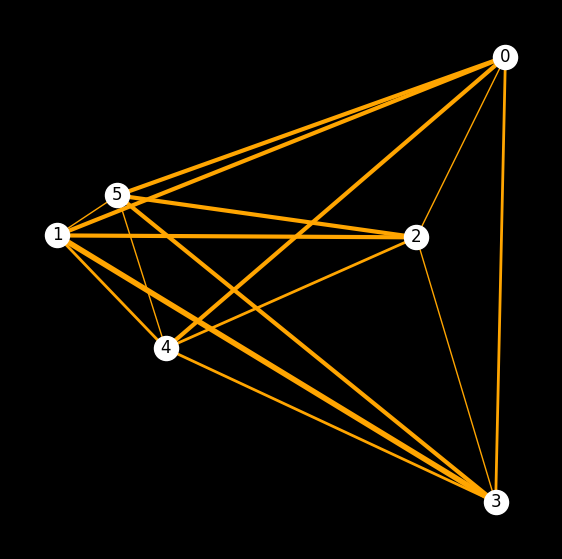

In [227]:
W = [ round(w) for w in cost ] # make these integers

if n <= 150: # skip the drawing when the graph is very large
    fig, ax = plt.subplots() # create an image to draw onto

    nx.draw(G, pos = gpos, # place each vertex at its coordinates
            edge_color = 'orange',
            width = W, # width from the cost
            **opt) # use the options above

    ax.set_facecolor('black') # make it a black background
    fig.set_facecolor('black')
    ax.axis('off') # no axis needed
    plt.show()
    plt.close()

For the **exhaustive** solution, we need to explore the tree of all the possible orderings of the visits. Here is a home-made implementation of a data structure to take care of that part. You can just take this at face value and skip ahead unless you are curious.

In [228]:
class Node: # now, consider all the possible visitation orders as a tree

    def __init__(self, label, parent = None, depth = 0): # create an empty node
        self.value = label # store the value
        self.parent = parent # root has none
        self.children = None # leaves have none
        self.depth = depth # the root is at zero
        self.height = None
        self.x = None
        self.y = None
        self.path = ''
        self.cost = 0
        self.total = 0
        self.label = None

    def adjust(self): # set values for height
        tallest = [ child.adjust() for child in self.children ] if self.children is not None else [ 0 ]
        self.height = 1 + max(tallest) # leaves have height one
        return self.height

    def __str__(self): # print the node (recursively the tree)
        prefix = ' ' * self.depth
        below = '\n'.join(str(child) for child in self.children) if self.children is not None else ''
        return f'{prefix}{self.path}\n{below}'.rstrip()

    def __repr__(self):
        return str(self) # when asked to represent, use the above format

    def present(self): # what values are already present at or above this one
        above = self.parent.present() if self.parent is not None else set()
        return { self.value } | above

    def permute(self, values, graph, root, best):
        if self.parent is not None: # not the root
            self.path = self.parent.path + '.' + str(self.value)
            # the cost of the edge from the parent to this one in the graph
            self.cost = graph[self.value][self.parent.value]['cost']
            self.total = self.cost + self.parent.total
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = graph[self.value][root.value]['cost']
            self.total += closing # close the loop
            return min(self.total, best)
        d = self.depth + 1 # the children will be one level deeper
        self.children = [ Node(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children: # continue recursively
            best = min(best, child.permute(below, graph, root, best))
        return best

    def position(self, ltarget, ptarget, xr, y, dy):
        self.label = f'{self.path} = {self.total:.2f}' # make a label with total cost
        ltarget[self.path] = self.label
        (xlow, xhigh) = xr
        self.x = (xlow + xhigh) / 2 # horizontally in the middle
        self.y = y # vertical position
        ptarget[self.label] = (self.x, self.y) # associate positions to the labels
        if self.children is not None:
            xspan = xhigh - xlow
            xa = xspan / len(self.children) # horizontal allocation per child
            for child in self.children:
                child.position(ltarget, ptarget, (xlow, xlow + xa), y - dy, dy)
                xlow += xa


    def join(self, graph): # add nodes as vertices to draw with networkx
        graph.add_node(self.path)
        if self.children is not None:
            for child in self.children:
                child.join(graph)

    def connect(self, graph): # add connections as edges to draw with networkx
        if self.parent is not None:
            v = self.label
            w = self.parent.label
            graph.add_edge(v, w, cost = self.cost)
        if self.children is not None:
            for child in self.children:
                child.connect(graph)

    def cheapest(self, best):
        if self.children is None: # at a leaf
            return min(self.total, best)
        else: # not at a leaf yet
            return min([ child.cheapest(best) for child in self.children ])

Of course we want to draw this as well, since we are learning about how things work.

The cheapest (exhaustive) route edgecosts 3.66
That took 5.03 ms of runtime


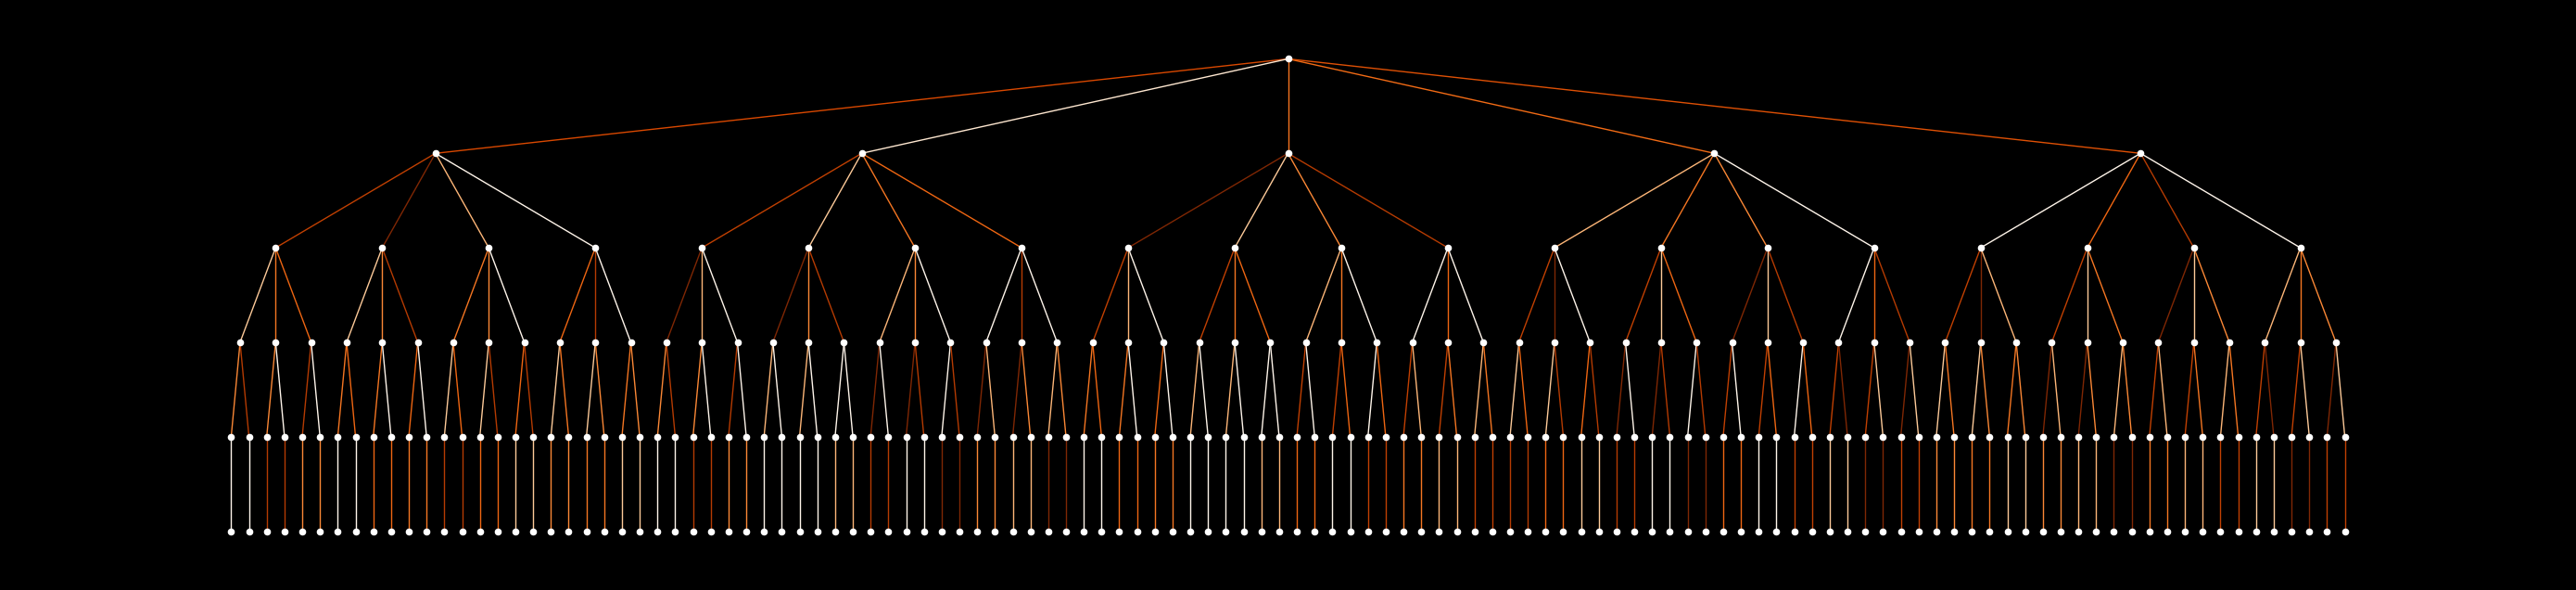

In [229]:
worst = max(cost)

opt['with_labels'] = n < 5
opt['font_color'] = 'cyan'
opt['node_size'] = 20

if n < 10: # too slow for larger graphs
    # note that it does not matter where we start since a TSP solution is a cycle
    start = time()
    groot = Node(0) # we can start at zero w.l.o.g.
    gbest = groot.permute({ v for v in range(n) }, G, groot, worst)
    print(f'The cheapest (exhaustive) route edgecosts {gbest:.2f}')
    timestamp(start)
    groot.adjust()
    T = nx.Graph() # we make a graph of it so we can draw it the same way
    groot.join(T) # create vertices to represent the nodes
    labels = dict()
    tpos = dict()
    plt.rcParams['figure.figsize'] = (wunit, unit) # big figure
    groot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    L = nx.relabel_nodes(T, labels)
    groot.connect(L) # add edges to represent the branches and match the edgecosts
    if n < 10: # makes no sense for large n to draw the trees
        fig, ax = plt.subplots()
        nx.draw(L, pos = tpos, # using the tree positions
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in L.edges(data = True) ], **opt)
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        plt.show()
        plt.close()

We can be smart and **prune** branches that cost more than *the best one seen thus far*. We will be object-oriented and inherit a new class from the `Node` defined above. Do not worry about what exactly this is unless you are supposed to know OOP; we are just adding a bit of new functionality to what we defined above to make it act smarter.

In [230]:
class Smart(Node):

    def __init__(self, label, parent = None, depth = 0):
        super().__init__(label, parent, depth)
        self.complete = False

    def role(self, target):
        # complete leaves are 1, incomplete leaves are 0, internals are -1
        target[self.label] = 1 * self.complete if self.children is None else -1
        if self.children is not None:
            for child in self.children:
                child.role(target)

    def permute(self, values, graph, root, best): # redefine how to proceed
        if self.parent is not None:
            self.path = self.parent.path + '.' + str(self.value)
            self.cost = graph[self.value][self.parent.value]['cost']
            self.total = self.cost + self.parent.total
            if self.total > best: # already more expensive, makes no sense to continue
                self.path += str(self.value) # leave early
                return best # this becomes an incomplete route if not a leaf yet
        else:
            self.path = str(self.value)
        pending = sorted(list(values - self.present())) # skip those already present
        if len(pending) == 0: # nothing left (a leaf)
            closing = graph[self.value][root.value]['cost']
            self.total += closing
            self.complete = True
            return min(self.total, best)
        d = self.depth + 1
        self.children = [ Smart(value, parent = self, depth = d) for value in pending ]
        below = values - { self.value }
        for child in self.children:
            best = min(best, child.permute(below, graph, root, best))
        return best

Let's see.

The cheapest (pruned) route edgecosts 3.66
That took 3.45 ms of runtime


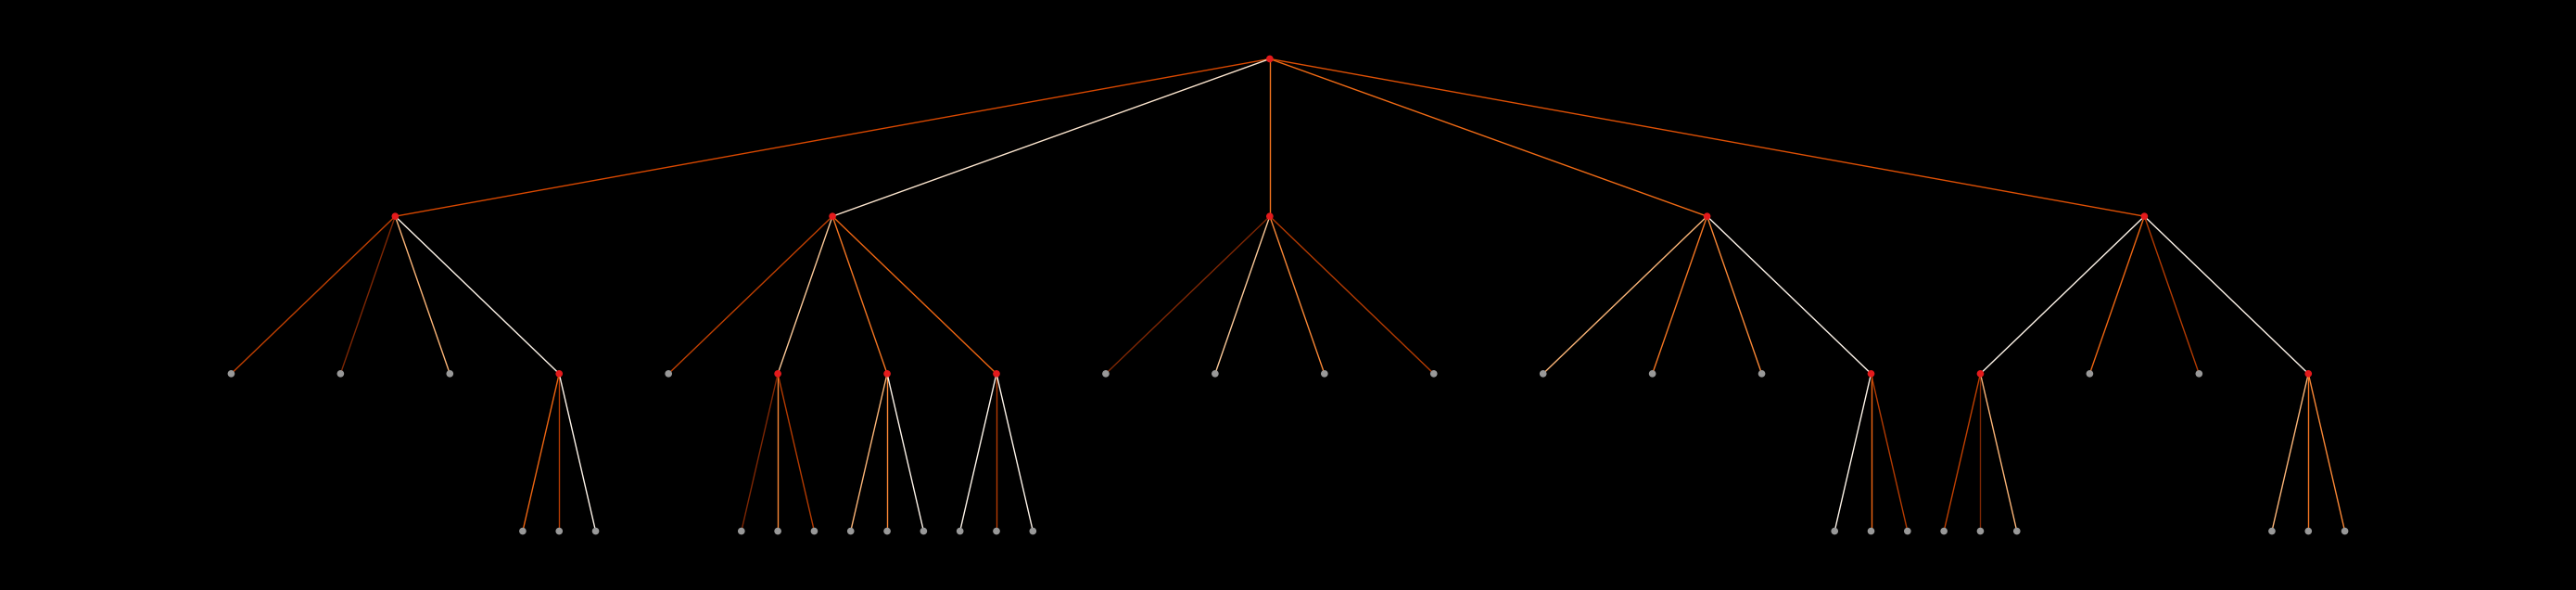

In [231]:
opt['font_color'] = 'cyan'
opt['font_size'] = 12

if n < 12:
    start = time()
    sroot = Smart(0)
    sbest = sroot.permute({ v for v in range(n) }, G, sroot, worst)
    print(f'The cheapest (pruned) route edgecosts {sbest:.2f}')
    timestamp(start)
    assert fabs(gbest - sbest) < significant
    sroot.adjust()
    P = nx.Graph()
    sroot.join(P)
    h = sroot.height
    sroot.position(labels, tpos, (0, w), 1, 1 / (n + 1)) # label and position the nodes with
    Q = nx.relabel_nodes(P, labels)
    sroot.connect(Q) # add edges to represent the branches and match the edgecosts
    del opt['node_color']
    if n < 10:
        complete = dict()
        sroot.role(complete)
        nodecolor = [ complete[v] for v in Q.nodes() ] # intermediate, full solution or pruned
        fig, ax = plt.subplots()
        nx.draw(Q, pos = tpos,
             node_color = nodecolor,
             cmap = plt.get_cmap('Set1'),
             edge_cmap = plt.get_cmap('Oranges'),
             edge_color = [ data['cost'] for v, w, data in Q.edges(data = True) ], **opt)
        ax.set_facecolor('black')
        fig.set_facecolor('black')
        ax.axis('off')
        plt.show()
        plt.close()

Neat, but very slow for larger graphs. Let's explore a quick-and-dirty alternative: *self-avoiding random walks*. To start with, we could use an auxiliary routine to tell us how much a route we have come up with actually costs.

In [232]:
def totalcost(G, r):
    acc = 0 # accumulate the cost here
    p = 1 # by traversing the route
    while p < len(r):
        source = r[p - 1]
        target = r[p]
        d = G.get_edge_data(source, target)
        assert 'cost' in d
        acc += d['cost']
        p += 1
    return acc

start = time()
route = [ v for v in range(n) ]
replicas = 100
rbest = n * worst
bestwalk = None

from random import shuffle

for replica in range(replicas): # try several times
    shuffle(route) # a new permutation
    cycle = route + [ route[0] ] # close the cycle
    c = totalcost(G, cycle)
    if c < rbest:
        rbest = c
        bestwalk = cycle.copy()
print(f'The cheapest random walk costs {rbest:.2f} (over {replicas} attempts)')
timestamp(start)
bestwalk

The cheapest random walk costs 8.98 (over 100 attempts)
That took 2.53 ms of runtime


[2, 3, 4, 5, 1, 0, 2]

Draw again? Of course. We can use a different color for the edges along the random walk.


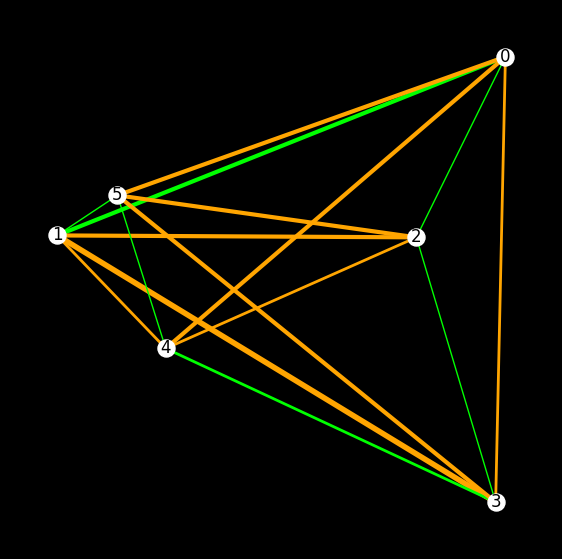

In [233]:
opt['node_size'] = 150
opt['node_color'] = 'white'
opt['with_labels'] = n <= 30
opt['font_color'] = 'black'
plt.rcParams['figure.figsize'] = (7, 7)

included = set()
for i in range(n):
  e = (bestwalk[i], bestwalk[i + 1])
  included.add(e)
  re = (e[1], e[0]) # reverse direction
  included.add(re)

colors = [ 'orange' if (u, v) not in included else 'lime' for u, v in G.edges()]

if n < 80: # this is pretty fast and legible
    fig, ax = plt.subplots()
    nx.draw(G, pos = gpos, #  each vertex at its coordinates
            width = W, # width from the cost
            edge_color = colors, # color depending on whether it is along the random walk
            **opt) # use the options above
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()

This is just a random solution but so fast we can make a bunch and pick the best. We could be more systematic about this, however.

A good way forward is to compute the MST of the graph and use that as a basis for building a cheap tour, but makes too many intermediate visits. We will use depth-first search (DFS) for this purpose.

In [234]:
mst = nx.minimum_spanning_tree(G, weight = "cost", algorithm = "kruskal")

bf = []
visited = set()

def dfs(v):
    global bf, visited
    bf.append(v)
    visited.add(v)
    cand = set(mst.neighbors(v)) - visited # unvisited
    for w in cand:
        dfs(w)
        bf.append(v)

start = time()
dfs(0)
if n <= 10:
    print('Back and forth', bf)

bfcost = totalcost(G, bf)
print(f'The back-and-forth MST costs {bfcost:.2f}')
timestamp(start)

Back and forth [0, 2, 3, 4, 5, 1, 5, 4, 3, 2, 0]
The back-and-forth MST costs 12.13
That took 0.65 ms of runtime


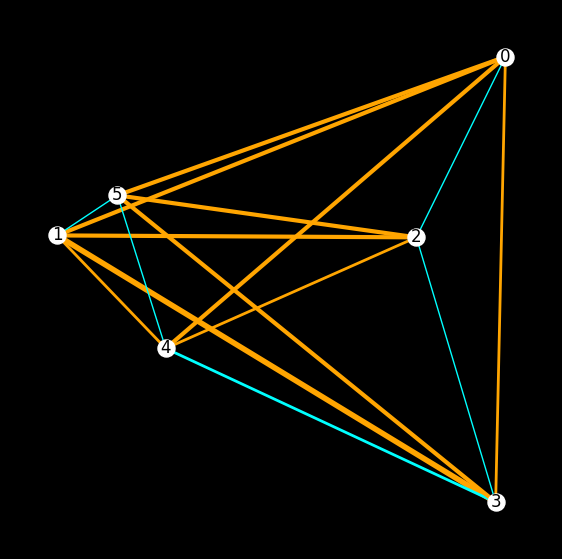

In [235]:
mc = [ 'cyan' if mst.has_edge(u, v) else 'orange' for u, v in G.edges()]

if n < 80: # also pretty fast and legible in most cases
    fig, ax = plt.subplots()
    nx.draw(G, pos = gpos, #  each vertex at its coordinates
            width = W, # width from the cost
            edge_color = mc, # color depending on whether it is part of the MST
            **opt) # use the options above
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()

Euclidean distance satisfies the triangle equality so if we had no noise, we would guarantee that we save on the total cost if we skip ahead on a direct edge instead of backtracking whenever that happens. We did add noise, so we lose the guarantee and our approach will no longer qualify as a bona fide **approximation algorithm **since we lose *the guaranteed upper bound of cost*, but it is still a perfectly valid heuristic.

In [236]:
start = time()
prev = 0 # start at zero again
straightened = [ 0 ]
for cand in bf:
    if cand not in straightened: # skip ahead if already visited
        straightened.append(cand)
straightened.append(0) # close the loop
if n <= 10:
    print('Straightened out', straightened)
for i in range(n):
    assert i in straightened

print(f'The straightened-out MST cycle costs {totalcost(G, straightened):.2f}')
timestamp(start)

Straightened out [0, 2, 3, 4, 5, 1, 0]
The straightened-out MST cycle costs 8.98
That took 1.78 ms of runtime


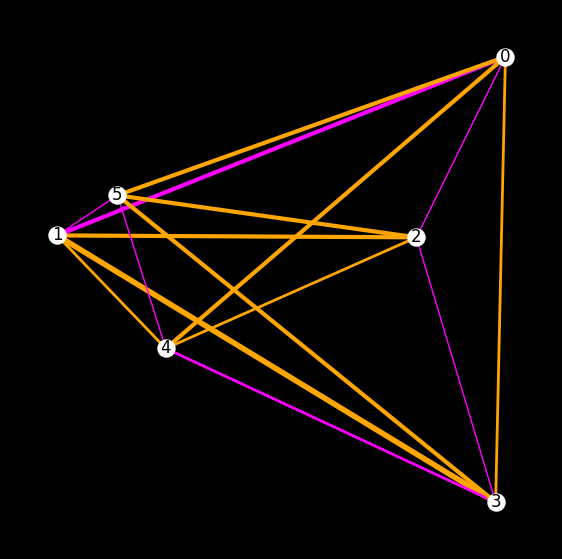

In [237]:
si = set()
for i in range(n):
  e = (straightened[i], straightened[i + 1])
  si.add(e)
  re = (e[1], e[0]) # reverse
  si.add(re)

sc = [ 'orange' if (u, v) not in si else 'magenta' for u, v in G.edges()]

if n < 80: # still fast and legible
    fig, ax = plt.subplots()
    nx.draw(G, pos = gpos, #  each vertex at its coordinates
            width = W, # width from the cost
            edge_color = sc, # color depending on whether it is along the random walk
            **opt) # use the options above
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()

Could this be further improved by making small alterations? Definitely. This approach is called *local search*.

We will make use of **the 2-opt heuristic**: take two edges *(a, b)* and *(c, d)* along the route and then then switch it around going from *a* to *c*, then backwards the original route from *b* to *c* and then continue from *b* to *d*, after which the rest of the route is as before. The result is that the edges *(a, b)* and *(c, d)* were removed and in their place we now have the edges *(a, c)* and *(b, d)*, so if the sum of the costs of the former exceed that of the latter, we win a little.

In [238]:
from random import randint

def twoopt(r):
    n = len(r)
    f = randint(1, n - 2) # first cut
    s = randint(f + 1, n - 1) # second cut
    start = r[:f]
    middle = r[f:s] # to invert
    finish = r[s:]
    assert len(start) > 0 and len(middle) > 0 and len(finish) > 0
    return start + middle[::-1] + finish

Since the way we are thinking this requires the two edges to be in the middle of the route instead of at the end of the beginning, we can also just roll the route around since it is a cycle and it does not *really* matter where we start.

In [239]:
def roll(r):
    k = len(r)
    assert r[0] == r[-1]
    offset = randint(1, k - 2)
    assert offset < len(r)
    rolled = r[offset:-1] + r[:offset]
    return rolled + [ rolled[0] ] # close it back

def restore(r):
    if r[0] == 0:
        assert r[-1] == 0
        return r # nothing to do here
    assert r[0] == r[-1]
    zero = r.index(0)
    unrolled = r[zero:-1] + r[:zero] + [0]
    return unrolled

We will use **simulated annealing** that lets us move from the *current* solution to a worse one, so we must keep at all times a copy of the *best* solution we have seen thus far so that we never lose that upper bound of being no more than twice above the cost of the MST.

You can mess with the initial temperature `T`and the cooling schedule `eps` to alter the probability with which worse solutions are accepted. Changing the `maximum` affects the amount of iterations that the search is allow to "stall" without improvement.

In [240]:
from math import exp

def simAnn(G, current, stuck = 30, maximum = 1000, \
           T = 1000, cooling = 0.999, eps = 0.01):
    stalled = 0
    stable = 0
    cheapest = current.copy()
    lcost = ccost = totalcost(G, current)
    i = 0
    while stalled < maximum and T > eps:
        assert current[0] == current[-1] == 0
        assert len(current) == n + 1
        modified = restore(twoopt(roll(current)))
        mcost = totalcost(G, modified)
        d = ccost - mcost
        if mcost < lcost: # a new low (a good thing here)
            print(f'New low at {mcost:.2f} on iteration {i} at temp {T:.2f}: {lcost:.2f}')
            cheapest = modified.copy()
            lcost = mcost
            if d > eps:
                stable += 1
                if stable > stuck:
                    stalled = maximum
                    continue
            else:
                stable = 0 # notable improvement
        threshold = exp(d / T) # probability
        i += 1
        if random() < threshold: # accept
            ccost = mcost
            current = modified
            if d > 0: # it was better
                T *= cooling # get stricter
                stalled = 0
                continue
        stalled += 1
    return cheapest

start = time()
# start with a copy of the straightened-out route
assert straightened[0] == straightened[-1] == 0
cheapest = simAnn(G, straightened.copy())
timestamp(start)

That took 934.76 ms of runtime


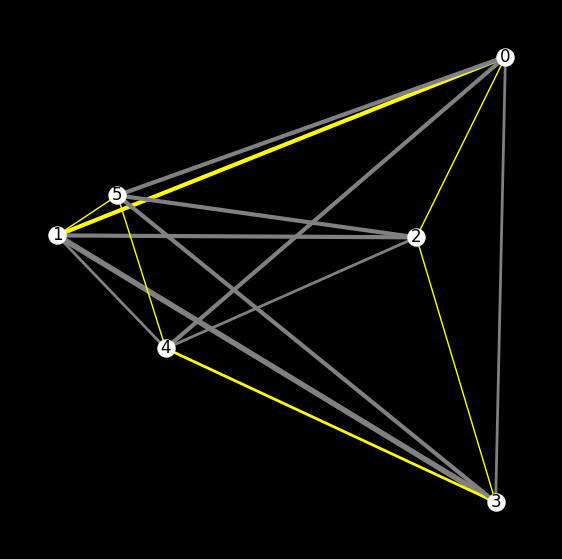

In [241]:
sc = set()
for i in range(n):
  e = (cheapest[i], cheapest[i + 1])
  sc.add(e)
  re = (e[1], e[0]) # reverse
  sc.add(re)

cc = [ 'gray' if (u, v) not in sc else 'yellow' for u, v in G.edges() ]

if n < 80:
    fig, ax = plt.subplots()
    nx.draw(G, pos = gpos, #  each vertex at its coordinates
            width = W, # width from the cost
            edge_color = cc, # color depending on whether it is along the random walk
            **opt) # use the options above
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.axis('off')
    plt.show()
    plt.close()